## 1. ENV

In [71]:
%pip install -U huggingface_hub chromadb langchain_google_genai sentence_transformers torch_geometric numpy tqdm datasets spacy nest_asyncio protobuf==3.20.3 langgraph

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
import logging, sys

logger = logging.getLogger()
logger.setLevel(logging.INFO)

if not logger.handlers:
    handler = logging.StreamHandler(sys.stdout)
    formatter = logging.Formatter("%(asctime)s [%(levelname)s] %(message)s")
    handler.setFormatter(formatter)
    logger.addHandler(handler)

logger.info("Dependencies installed successfully.")

INFO:root:Dependencies installed successfully.


In [21]:
import os
from dotenv import load_dotenv
from huggingface_hub import login
import torch

TORCH = print(torch.__version__)
CUDA = print(torch.version.cuda)
SEED = 42

load_dotenv()
login(token=os.getenv('HF_TOKEN'))
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
if not GOOGLE_API_KEY:
    raise ValueError("GOOGLE_API_KEY not found in environment variables.")

import torch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")


2.6.0+cu124
12.4


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Using device: cuda


## 2. Dataset loading

data loading

In [22]:
# load the Qasper dataset
from datasets import load_dataset, Dataset
dataset = load_dataset("allenai/qasper", cache_dir='./data/Qasper/qasper_cache')

# shuffle
trainset = dataset['train'] #.shuffle(seed=SEED)
validset = dataset['validation'] #.shuffle(seed=SEED)
testset  = dataset['test'] #.shuffle(seed=SEED)

INFO:numexpr.utils:NumExpr defaulting to 12 threads.
INFO:datasets:PyTorch version 2.6.0+cu124 available.
INFO:datasets:Polars version 1.21.0 available.
INFO:datasets:Duckdb version 1.2.2 available.
INFO:datasets:TensorFlow version 2.18.0 available.
INFO:datasets:JAX version 0.5.2 available.


README.md: 0.00B [00:00, ?B/s]

qasper.py: 0.00B [00:00, ?B/s]

qasper/train/0000.parquet:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

qasper/validation/0000.parquet:   0%|          | 0.00/4.75M [00:00<?, ?B/s]

qasper/test/0000.parquet:   0%|          | 0.00/7.07M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/888 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/281 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/416 [00:00<?, ? examples/s]

data preprocessing: ensure data integrity

In [23]:
import re
from copy import deepcopy
from typing import Dict, List

FLOAT_TAG = "FLOAT SELECTED: "  # evidence에서 제거할 태그
REF_TAG = re.compile(r" BIBREF\d+")
# FIG_TAG = re.compile(r" FIGREF\d+")

def _clear_tag(ev_list: List[str]) -> List[str]:
    """evidence 리스트에서 'FLOAT SELECTED: ' 부분 문자열을 삭제하고
       내용이 남은 evidence만 반환
    """
    cleaned = []
    for ev in ev_list:
        new_ev = ev.replace(FLOAT_TAG, "")
        new_ev = REF_TAG.sub("", new_ev)
        new_ev = new_ev.strip()
        if new_ev:                       # 치환 후 내용이 남아 있을 때만 보존
            cleaned.append(new_ev)
    return cleaned

def filter_sample(sample: Dict) -> Dict:
    """Qasper 샘플에서 'FLOAT SELECTED: ' 태그를 제거하고
       내용이 남지 않는 answer-detail / question 을 드롭
    """
    new_qas = {k: [] for k in sample["qas"]}

    for idx in range(len(sample["qas"]["question"])):
        blk = deepcopy(sample["qas"]["answers"][idx])

        kept_det, kept_ann, kept_wid = [], [], []
        for det, ann, wid in zip(blk.get("answer", []),
                                 blk.get("annotation_id", []),
                                 blk.get("worker_id", [])):

            cleaned_ev = _clear_tag(det.get("evidence", []))
            if cleaned_ev:                               # evidence가 하나라도 남을 때만 keep
                det = deepcopy(det)
                det["evidence"] = cleaned_ev
                kept_det.append(det)
                kept_ann.append(ann)
                kept_wid.append(wid)

        if kept_det:                                    # 질문 유지 여부
            blk.update(
                answer        = kept_det,
                annotation_id = kept_ann,
                worker_id     = kept_wid,
            )
            new_qas["answers"].append(blk)
            for k in sample["qas"]:
                if k != "answers":
                    new_qas[k].append(sample["qas"][k][idx])

    # Update the sample full_text paragraph with cleaned QAs
    for j, paragraph in enumerate(sample['full_text']['paragraphs']):
        for sub_paragraph in paragraph:
            # Clean the sub-paragraph text
            cleaned_text = sub_paragraph.replace(FLOAT_TAG, "")
            cleaned_text = REF_TAG.sub("", cleaned_text).strip()
            # cleaned_text = FIG_TAG.sub("", cleaned_text).strip()

            sub_paragraph = cleaned_text

    sample["qas"] = new_qas
    return sample


In [24]:
# Apply the filtering function to every sample in the trainset.
trainset = trainset.map(filter_sample)
validset = validset.map(filter_sample)
testset = testset.map(filter_sample)

Map:   0%|          | 0/888 [00:00<?, ? examples/s]

Map:   0%|          | 0/281 [00:00<?, ? examples/s]

Map:   0%|          | 0/416 [00:00<?, ? examples/s]

validate data pre processing

In [25]:
def validate_evidence_clean(sample: Dict) -> bool:
    """
    1. evidence가 비어 있지 않은지
    2. evidence 안에 placeholder 문자열이 남아 있지 않은지
    모두 만족하면 True
    """
    ok = True
    for q_idx, blk in enumerate(sample["qas"]["answers"]):
        for a_idx, det in enumerate(blk["answer"]):
            ev = det.get("evidence", [])
            if not ev:
                print(f"[오류] Q{q_idx}-A{a_idx}: evidence가 비어 있습니다.")
                ok = False
                continue
    return ok

def validate_no_float_selected(sample: Dict) -> bool:
    """모든 evidence에 'FLOAT SELECTED: ' 문자열이 남아 있지 않은지 확인"""
    ok = True
    for q_idx, blk in enumerate(sample["qas"]["answers"]):
        for a_idx, det in enumerate(blk["answer"]):
            for ev in det.get("evidence", []):
                if FLOAT_TAG in ev:
                    print(f"[오류] Q{q_idx}-A{a_idx}: 미제거 태그 발견 → “{ev}”")
                    ok = False
    return ok


def validate_all_samples(dataset):
    """모든 샘플에 대해 evidence가 비어 있거나 미제거 태그가 있는지 확인"""
    is_not_clean = True
    for i, sample in enumerate(dataset):
        if not validate_evidence_clean(sample):
            print(f"[오류] 샘플 #{i}에 빈 evidence가 존재합니다.")
            return False
        if not validate_no_float_selected(sample):
            print(f"[오류] 샘플 #{i}에 미제거 태그가 존재합니다.")
            return False
    return True


In [26]:
if not validate_all_samples(trainset):
    raise ValueError("Trainset validation failed.")
if not validate_all_samples(validset):
    raise ValueError("Validset validation failed.")
if not validate_all_samples(testset):
    raise ValueError("Testset validation failed.")

***
## Embed sentences as nodes

In [27]:
import os, re, hashlib, itertools, shutil, json, time
from pathlib import Path
from typing import List, Tuple, Dict, Iterable

HF_CACHE_FOLDER     = "./data/.cache/scibert-nli"
# CHROMA_DIR          = "./demo_chroma_db"
# CHROMA_DIR          = "./chroma_qasper_10"
COLLECTION_SENT_NAME     = "paper_sentences"
COLLECTION_RELA_NAME     = "paper_relations"


# Clean previous run
# if Path(CHROMA_DIR).exists():
#     shutil.rmtree(CHROMA_DIR)

In [28]:
from sentence_transformers import SentenceTransformer
print("▸ Loading SentenceTransformer …")
# os.environ['HF_HOME'] = './data/.cache'  # Set cache directory for HuggingFace models
ENC_MODEL = SentenceTransformer('gsarti/scibert-nli', cache_folder=HF_CACHE_FOLDER, device=DEVICE)
if not ENC_MODEL:
    raise RuntimeError("Failed to load the SentenceTransformer model.")

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: gsarti/scibert-nli


▸ Loading SentenceTransformer …


config.json:   0%|          | 0.00/450 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/135 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [29]:
from langchain_google_genai import ChatGoogleGenerativeAI

print("▸ Loading Gemini 1.5 Flash model …")
GOOGLE_API_KEY = os.environ["GOOGLE_API_KEY"]
LLM = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    google_api_key=GOOGLE_API_KEY,
    temperature=0.0
)
if not LLM:
    raise RuntimeError("Failed to load the Gemini 1.5 Flash model.")
else: print("▸ Gemini 1.5 Flash loaded (LangChain wrapper).")

LABELS = ["Claim", "Evidence", "Background", "Method", "Result",
          "Interpretation", "Contrast", "Cause-Effect",
          "Temporal", "Condition", "Other"]
LABEL2IDX = {lab: i for i, lab in enumerate(LABELS)}

# Not used in this script, but use for further study
PROMPT = """\
[MUST FOLLOW Task]:
1. You are an academic discourse analyst.
2. Classify how Sentence_B is related to Sentence_A using EXACTLY ONE "Allowed labels".
3. If none apply, output "Other".

[Allowed labels]:
Claim, Evidence, Background, Method, Result, Interpretation,
Contrast, Cause-Effect, Temporal, Condition, Other

[Sentence pairs]:
{PAIRS}

Respond only with a list of labels, in order:
1: <label>
2: <label>
...
{N}: <label>
"""

def one_hot_encode_labels(labels: list[str]) -> list[list[float]]:
    index = {l: i for i, l in enumerate(LABELS)}
    vecs = []
    for l in labels:
        vec = [0.0] * len(LABELS)
        vec[index.get(l, -1)] = 1.0 if l in index else 0.0
        vecs.append(vec)
    return vecs

def format_sentence_pairs(pairs: list[tuple[str, str]]) -> str:
    return "\n".join([
        f"{i+1}.\nSentence_A: {a}\nSentence_B: {b}"
        for i, (a, b) in enumerate(pairs)
    ])

def parse_llm_labels(response: str, expected: int) -> List[str]:
    lines = response.strip().splitlines()
    labels = []

    for line in lines:
        if ":" not in line:
            continue                   # 형식 일치하지 않으면 스킵
        _, raw = line.split(":", 1)
        lbl = raw.strip()
        if not lbl or lbl not in LABELS:
            lbl = "Other"  # 유효하지 않은 라벨은 "Other"로 대체
        labels.append(lbl)

    # 부족한 개수만큼 패딩
    if len(labels) < expected:
        labels.extend(["Other"] * (expected - len(labels)))

    # 초과하면 앞 expected개만 사용
    return labels[:expected]

▸ Loading Gemini 1.5 Flash model …
▸ Gemini 1.5 Flash loaded (LangChain wrapper).


In [30]:
import spacy
nlp = spacy.load("en_core_web_sm")

def split_sentences(paragraph: str) -> list[str]:
    """spaCy를 이용해 문단을 문장 단위로 분할"""
    doc = nlp(paragraph.strip())
    return [sent.text.strip() for sent in doc.sents if sent.text.strip()]

In [80]:
import chromadb

print("▸ Initialising ChromaDB …")
CHROMA_DIR = './drive/MyDrive/chroma_db_2'
# CHROMA_DIR = './chroma_full_db'
print(CHROMA_DIR)
client = chromadb.PersistentClient(path=CHROMA_DIR)
col_tmp       = client.get_or_create_collection(name="tmp_collection") # tmp example collection
col_sent_tra  = client.get_or_create_collection(name=COLLECTION_SENT_NAME)
col_rel_tra   = client.get_or_create_collection(name=COLLECTION_RELA_NAME)

col_sent_val = client.get_or_create_collection(name="sent_val")
col_rel_val  = client.get_or_create_collection(name="rel_val")

col_sent_test = client.get_or_create_collection(name="sent_test")
col_rel_test  = client.get_or_create_collection(name="rel_test")


▸ Initialising ChromaDB …
./drive/MyDrive/chroma_db_2


In [32]:
import numpy as np, hashlib
from tqdm import tqdm
from datasets import DatasetDict
from typing import Dict, Iterable, Tuple, Optional

def generate_sent_nodes(dataset: DatasetDict) -> Iterable[Dict]:
    for sample in tqdm(dataset, total=len(dataset), desc="Generating nodes"):
        paper_id = sample["id"]

        for sec_idx, (sec_name, sec_content) in enumerate(
                zip(sample["full_text"]["section_name"],
                    sample["full_text"]["paragraphs"])):

            if sec_name == "" or sec_name is None: continue  # 섹션 이름이 비어 있으면 스킵
            sec_name = sec_name.strip()

            yield {
                "sid":  hashlib.sha1(f"{paper_id}/sec{sec_idx}".encode()).hexdigest(),
                "sent": sec_name,
                "prev": None,
                "meta": dict(paper_id=paper_id, sec_idx=sec_idx,
                               para_idx=-1, sent_idx=-1)
            }

            for para_idx, para in enumerate(sec_content):
                sentences = split_sentences(para.strip())

                if sentences == "": continue

                prev: Optional[Tuple[str, str]] = None

                for sent_idx, sent in enumerate(filter(None, sentences)):
                    para_id = f"{paper_id}/sec{sec_idx}/para{para_idx}"
                    path = f"{para_id}/sent{sent_idx}"
                    sid  = hashlib.sha1(path.encode()).hexdigest()

                    yield {
                        "sid":    sid,
                        "sent":   sent.strip(),
                        "prev":   prev,
                        "meta":   dict(paper_id=paper_id, sec_idx=sec_idx,
                                       para_idx=para_idx, sent_idx=sent_idx)
                    }
                    prev = dict(sid=sid, sent=sent.strip())  # skips first sentence in paragraph

In [33]:
import asyncio
from concurrent.futures import ThreadPoolExecutor
from typing import List, Tuple


WORKERS = 4  # Number of worker threads for async processing
executor = ThreadPoolExecutor(max_workers=WORKERS)
flush_semaphore = asyncio.Semaphore(WORKERS)

async def flush_sentence_async(ids, sents, metas, collection):
    async with flush_semaphore:
        loop = asyncio.get_event_loop()
        def encode_and_upsert():
            logger.info(f"[Upsert] starting upsert for {collection.name} collection with {len(ids)} sentences.")
            try:
                if not ids:
                    return
                embs = ENC_MODEL.encode(
                    sents,
                    convert_to_numpy=True,
                    normalize_embeddings=True,
                    batch_size=len(sents),
                    show_progress_bar=False,
                    device=DEVICE
                )
                collection.upsert(
                    ids=ids,
                    embeddings=embs,
                    documents=sents,
                    metadatas=metas
                )
                logger.info(f"▸ [Upserted] {len(ids)} sentences to {collection.name} collection.")
                logger.info(f"{collection.count()} total sentences")
            except Exception as e:
                logging.error(f"[Upsert Error] ids={ids[:3]}...: {e}")

        await loop.run_in_executor(executor, encode_and_upsert)

In [34]:
async def process_dataset(nodes, collection, batch_sent=600, batch_pairs=50):
    ids, sents, metas = [], [], []
    pair_buf          = []
    tasks             = []

    for node in nodes:
        ids.append(node["sid"])
        sents.append(node["sent"])
        metas.append(node["meta"])

        if node["prev"]:
            # print(f"Processing pair: {node['prev']['sid']} -> {node['sid']}")
            pair_buf.append(dict(meta=node['meta'],
                             prev_sid=node["prev"]["sid"],  curr_sid=node["sid"],
                             prev_sen=node["prev"]["sent"], curr_sen=node["sent"]))

        if len(ids) >= batch_sent:
            ids_copy = ids.copy()
            sents_copy = sents.copy()
            metas_copy = metas.copy()

            tasks.append(
                asyncio.create_task(
                    flush_sentence_async(ids_copy, sents_copy, metas_copy, collection)
                )
            )
            ids, sents, metas = [], [], []

    if ids:
        ids_copy   = ids.copy()
        sents_copy = sents.copy()
        metas_copy = metas.copy()
        tasks.append(
            asyncio.create_task(
                flush_sentence_async(ids_copy, sents_copy, metas_copy, collection)
            )
        )

    # 모든 병렬 작업 종료 대기
    if tasks:
        await asyncio.gather(*tasks)

In [14]:
print(f"▸ Stored sentences: {col_tmp.count():}")
print(f"▸ Stored sentences: {col_sent_tra.count():}")
print(f"▸ Stored sentences: {col_rel_tra.count():}")
print(f"▸ Stored sentences: {col_sent_val.count():}")
print(f"▸ Stored sentences: {col_rel_val.count():}")
print(f"▸ Stored sentences: {col_sent_test.count():}")
print(f"▸ Stored sentences: {col_rel_test.count():}")

▸ Stored sentences: 1024
▸ Stored sentences: 173633
▸ Stored sentences: 0
▸ Stored sentences: 40151
▸ Stored sentences: 0
▸ Stored sentences: 55738
▸ Stored sentences: 0


In [35]:
import nest_asyncio
nest_asyncio.apply()  # Allow nested event loops in Jupyter

print("▸ Embedding sentences + relations …")
# await process_dataset(nodes=generate_sent_nodes(trainset), collection=col_sent_tra)
await process_dataset(nodes=generate_sent_nodes(validset), collection=col_sent_val)
await process_dataset(nodes=generate_sent_nodes(testset), collection=col_sent_test)
print("▸ Done embedding sentences + relations.")
print(f"▸ Stored sentences: {col_sent_tra.count():}")
print(f"▸ Stored sentences: {col_sent_val.count():}")
print(f"▸ Stored sentences:{col_sent_test.count():}")

▸ Embedding sentences + relations …


Generating nodes: 100%|██████████| 281/281 [03:37<00:00,  1.29it/s]
INFO:root:[Upsert] starting upsert for sent_val collection with 600 sentences.
INFO:root:[Upsert] starting upsert for sent_val collection with 600 sentences.
INFO:root:[Upsert] starting upsert for sent_val collection with 600 sentences.
INFO:root:[Upsert] starting upsert for sent_val collection with 600 sentences.
INFO:root:▸ [Upserted] 600 sentences to sent_val collection.
INFO:root:40327 total sentences
INFO:root:[Upsert] starting upsert for sent_val collection with 600 sentences.
INFO:root:▸ [Upserted] 600 sentences to sent_val collection.
INFO:root:40927 total sentences
INFO:root:[Upsert] starting upsert for sent_val collection with 600 sentences.
INFO:root:▸ [Upserted] 600 sentences to sent_val collection.
INFO:root:40927 total sentences
INFO:root:[Upsert] starting upsert for sent_val collection with 600 sentences.
INFO:root:▸ [Upserted] 600 sentences to sent_val collection.
INFO:root:41527 total sentences
INFO:ro

▸ Done embedding sentences + relations.
▸ Stored sentences: 173633
▸ Stored sentences: 50391
▸ Stored sentences:74170


(800,888)

In [ ]:
# !cp -r /content/chroma_full_db/ /content/drive/MyDrive/Colab_Backups2/

Training

In [36]:
# re load the collections
from chromadb import PersistentClient
print(CHROMA_DIR)
client = PersistentClient(path=CHROMA_DIR)
col_sent_tra =client.get_or_create_collection(name=COLLECTION_SENT_NAME)
col_rel_tra = client.get_or_create_collection(name=COLLECTION_RELA_NAME)
col_sent_val = client.get_or_create_collection(name="sent_val")
col_rel_val = client.get_or_create_collection(name="rel_val")
print(f"col_tmp: {col_tmp.count()}")
print(f"col_sent: {col_sent_tra.count()}")
print(f"col_sent_val: {col_sent_val.count()}")
print(f"col_sent_test: {col_sent_test.count()}")

./drive/MyDrive/chroma_db_2
col_tmp: 1024
col_sent: 173633
col_sent_val: 50391
col_sent_test: 74170


In [37]:
from collections import defaultdict
from torch_geometric.data import HeteroData
import torch
from tqdm import tqdm

def generate_paper_hier_graph(collection: chromadb.Collection, embed_dim: int = 768):
    # === Prepare Graph Generation ===
    # 1) load data
    sent_data = collection.get(include=["embeddings","metadatas"])
    node_ids   = sent_data["ids"]
    metas      = sent_data["metadatas"]
    all_embs   = torch.tensor(sent_data["embeddings"], dtype=torch.float32)

    # 2) map section text embedding (sperate from sent embeddings)
    section_emb_map = {}
    for idx, meta in enumerate(metas):
        if meta["para_idx"] == -1:
            key = (meta["paper_id"], meta["sec_idx"])
            section_emb_map[key] = all_embs[idx]

    # 3) Generate Tree structure dict (per paper)
    tree = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    for sid, meta in zip(node_ids, metas):
        if meta["para_idx"] >= 0:
            pid, s, p = meta["paper_id"], meta["sec_idx"], meta["para_idx"]
            tree[pid][s][p].append(sid)

    graphs = []
    for pid, secs in tqdm(tree.items(), desc="Generating graphs"):
        data = HeteroData()

        # === Add Nodes ===
        # paper: learnable hub node embedding, no .x
        data["paper"].num_nodes = 1

        # section: section text embeddings
        sec_indices = list(secs.keys())
        data["section"].num_nodes = len(sec_indices)
        data["section"].x = torch.stack([
            section_emb_map[(pid, sec_idx)]
            for sec_idx in sec_indices
        ], dim=0)

        # paragraph: learnable hub node embedding, no .x
        para_keys = [(s, p) for s, paras in secs.items() for p in paras]
        data["paragraph"].num_nodes = len(para_keys)

        # Add sentence text embeddings
        sent_sids = [sid for paras in secs.values() for lst in paras.values() for sid in lst]
        idx_map   = {sid:i for i, sid in enumerate(sent_sids)}
        data["sentence"].x = all_embs[[ node_ids.index(sid) for sid in sent_sids ]]

        # === Add Edges ===
        # paper > section
        sec_src = torch.zeros(len(sec_indices), dtype=torch.long)
        sec_dst = torch.arange(len(sec_indices), dtype=torch.long)
        data["paper","has_section","section"].edge_index = torch.stack([sec_src, sec_dst], dim=0)
        # reverse direction edge
        data["section","rev_has_section","paper"].edge_index = \
            data["paper","has_section","section"].edge_index.flip(0)

        # section > paragraph
        sec_map = {s:i for i, s in enumerate(sec_indices)}
        para_src = [sec_map[s] for s,_ in para_keys]
        para_dst = list(range(len(para_keys)))
        data["section","has_paragraph","paragraph"].edge_index = torch.tensor([para_src, para_dst])
        # reverse direction edge
        data["paragraph","rev_has_paragraph","section"].edge_index = \
            data["section","has_paragraph","paragraph"].edge_index.flip(0)

        # paragraph > sentence
        para_map = {k:i for i,k in enumerate(para_keys)}
        sent_src = [para_map[(metas[node_ids.index(sid)]["sec_idx"],
                              metas[node_ids.index(sid)]["para_idx"])]
                    for sid in sent_sids]
        sent_dst = [idx_map[sid] for sid in sent_sids]
        data["paragraph","has_sentence","sentence"].edge_index = torch.tensor([sent_src, sent_dst])
        # reverse direciton edge
        data["sentence","rev_has_sentence","paragraph"].edge_index = \
            data["paragraph","has_sentence","sentence"].edge_index.flip(0)

        graphs.append(data)

    return graphs


In [39]:
train_data_list = generate_paper_hier_graph(col_sent_tra)
valid_data_list = generate_paper_hier_graph(col_sent_val)
test_data_list  = generate_paper_hier_graph(col_sent_test)

Generating graphs: 100%|██████████| 416/416 [02:28<00:00,  2.81it/s]


Visualize paper constructed tree before training

In [77]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_sentence_hierarchy_filtered(data: HeteroData, n: int = 10, figsize=(8, 6)):
    """
    Get first/last n sentences in HeteroData
    than Visualize sentence > paragraph > section > paper connection
    """
    # 1. get edge_index
    para_sent = data['paragraph', 'has_sentence', 'sentence'].edge_index
    sec_para  = data['section',   'has_paragraph','paragraph'].edge_index
    pap_sec   = data['paper',     'has_section', 'section'].edge_index

    # 2. select sentence indices
    num_sent = data['sentence'].num_nodes
    first_idx = list(range(min(n, num_sent)))
    last_idx  = list(range(max(0, num_sent - n), num_sent))
    selected_sent = set(first_idx + last_idx)

    # 3. set of sentences's parent paragraph
    selected_para = {
        u.item()
        for u, v in zip(para_sent[0], para_sent[1])
        if v.item() in selected_sent
    }

    # 4. set of paragraph's parent section
    selected_sec = {
        u.item()
        for u, v in zip(sec_para[0], sec_para[1])
        if v.item() in selected_para
    }

    # 5. set of section's parent paper
    selected_pap = {
        u.item()
        for u, v in zip(pap_sec[0], pap_sec[1])
        if v.item() in selected_sec
    }

    G = nx.DiGraph()

    # 6. get first node = paper node
    for p in selected_pap:
        pap_node = f"paper_{p}"
        G.add_node(pap_node, type='paper')

    # 7. Add section node, paper <-> section edges
    for u, v in zip(pap_sec[0], pap_sec[1]):
        if u.item() in selected_pap and v.item() in selected_sec:
            sec_node = f"section_{v.item()}"
            pap_node = f"paper_{u.item()}"
            G.add_node(sec_node, type='section')
            G.add_edge(pap_node, sec_node)
            G.add_edge(sec_node, pap_node)  # reverse edge

    # 8. Add paragraph node, section <-> paragraph edges
    for u, v in zip(sec_para[0], sec_para[1]):
        if u.item() in selected_sec and v.item() in selected_para:
            para_node = f"paragraph_{v.item()}"
            sec_node  = f"section_{u.item()}"
            G.add_node(para_node, type='paragraph')
            G.add_edge(sec_node, para_node)
            G.add_edge(para_node, sec_node)  # reverse edge

    # 9. Add sentence node, paragraph <-> sentence edges
    for u, v in zip(para_sent[0], para_sent[1]):
        if v.item() in selected_sent:
            sent_node = f"sentence_{v.item()}"
            para_node = f"paragraph_{u.item()}"
            G.add_node(sent_node, type='sentence')
            G.add_edge(para_node, sent_node)
            G.add_edge(sent_node, para_node) # reverse edge

    # 10. Set node positions manually
    layer_map = {'paper':0, 'section':1, 'paragraph':2, 'sentence':3}

    # 11. sort nodes by layer
    nodes_by_layer = {
        t: sorted([n for n,d in G.nodes(data=True) if d['type']==t],
                key=lambda n: int(n.split('_')[1]))
        for t in layer_map.keys()
    }

    # 12. Create positions for each node
    pos = {}
    for t, nodes in nodes_by_layer.items():
        x = layer_map[t]
        L = len(nodes)
        for i, n in enumerate(nodes):
            # y position ... layer
            y = 0 if L==1 else 1 - 2*(i/(L-1))
            pos[n] = (x, y)

    color_map = {
        'paper':     '#A6CEE3',
        'section':   '#B2DF8A',
        'paragraph': '#FB9A99',
        'sentence':  '#CAB2D6',
    }
    node_colors = [color_map[G.nodes[n]['type']] for n in G.nodes()]
    labels = {n: n for n in G.nodes()}

    plt.figure(figsize=figsize)
    nx.draw(
        G, pos,
        node_color=node_colors,
        labels=labels,
        with_labels=True,
        node_size=500,
        font_size=6,
        arrowsize=12,
        arrowstyle='-|>'
    )
    plt.title(f"Filtered Sentence Hierarchy (first/last {n} sentences)")
    plt.axis('off')
    plt.show()


Generating graphs: 100%|██████████| 5/5 [00:00<00:00, 137.77it/s]


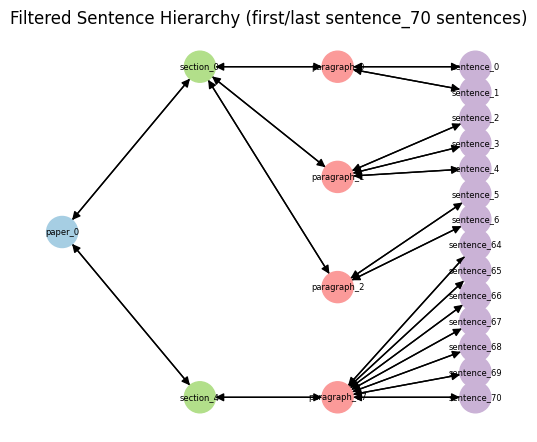

In [79]:
tmp_graph = generate_paper_hier_graph(col_tmp, embed_dim=ENC_MODEL.get_sentence_embedding_dimension())
data = tmp_graph[1]
visualize_sentence_hierarchy_filtered(data, n=7, figsize=(5, 4))

In [59]:
import torch
import copy
from typing import Optional

class EarlyStopping:
    def __init__(
        self,
        patience: int = 10,
        min_delta: float = 1e-3,
        save_path: str = "best_model.pth"
    ):
        self.patience = patience
        self.min_delta = min_delta
        self.save_path = save_path

        self.best_score: Optional[float] = None
        self.counter: int = 0
        self.best_state_dict: Optional[dict] = None

    def step(self, score: float, model: torch.nn.Module) -> bool:
        if self.best_score is None or score < self.best_score - self.min_delta:
            self.best_score = score
            self.counter = 0
            self.best_state_dict = copy.deepcopy(model.state_dict())
            torch.save(self.best_state_dict, self.save_path)

            return False

        self.counter += 1
        if self.counter >= self.patience:
            return True

        return False

    def load_best_model(self, model: torch.nn.Module) -> None:
        if self.best_state_dict is None:
            raise ValueError("최적 모델이 저장된 적이 없습니다.")
        model.load_state_dict(self.best_state_dict)


In [60]:
from torch_geometric.utils import negative_sampling

def compute_edge_similarities(h, edge_index):
    # Calculate positive similarity
    src, dst = edge_index    # [2, E]
    pos_sim  = (h[src] * h[dst]).sum(dim=1)  # [E]

    # Negative sampling (src.size(0) = E)
    neg_idx  = negative_sampling(
        edge_index=edge_index,
        num_nodes=h.size(0),
        num_neg_samples=src.size(0),
        method='dense'    # dense is faster for small graphs
    )

    # Calculate negative similarity
    ns, nd   = neg_idx
    neg_sim  = (h[ns] * h[nd]).sum(dim=1)    # [E]

    return pos_sim, neg_sim

In [64]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import HGTConv
from torch_geometric.nn.norm import GraphNorm

class HGTWithProjGraphLayerNorm(torch.nn.Module):
    def __init__(
        self,
        in_dim: int,
        hidden_dim: int,
        metadata,
        hub_node_counts: dict[str,int],
        num_heads: int = 2,
        dropout: float = 0.2,
        proj_dim: int | None = None,
    ):
        """
        in_dim           : 입력 특성 차원 (예: 768)
        hidden_dim       : HGTConv 은닉 차원
        metadata         : HeteroData.metadata()
        hub_node_counts  : {'paper':…, 'paragraph':…} 형태의 hub 노드 수
        num_heads        : 어텐션 헤드 수
        dropout          : 드롭아웃 확률
        proj_dim         : Projection head의 출력 차원 (None이면 hidden_dim 사용)
        """
        super().__init__()
        node_types, _ = metadata

        # 1. learnable hub embeddings for paper and paragraph
        self.hub_embeddings = torch.nn.ParameterDict({
            ntype: torch.nn.Parameter(torch.randn(count, in_dim))
            for ntype, count in hub_node_counts.items()
            if ntype in ("paper", "paragraph")
        })

        # 2. input projection from in dim to hidden dim
        self.lin_dict = torch.nn.ModuleDict({
            ntype: torch.nn.Linear(in_dim, hidden_dim)
            for ntype in node_types
        })

        # 3. two layers of HGTConv
        self.conv1 = HGTConv(hidden_dim, hidden_dim, metadata, heads=num_heads)
        self.conv2 = HGTConv(hidden_dim, hidden_dim, metadata, heads=num_heads)

        # 4. graph norm and layer norm
        self.gnorm1 = torch.nn.ModuleDict({
            ntype: GraphNorm(hidden_dim) for ntype in node_types
        })
        self.lnorm1 = torch.nn.ModuleDict({
            ntype: torch.nn.LayerNorm(hidden_dim) for ntype in node_types
        })
        self.gnorm2 = torch.nn.ModuleDict({
            ntype: GraphNorm(hidden_dim) for ntype in node_types
        })
        self.lnorm2 = torch.nn.ModuleDict({
            ntype: torch.nn.LayerNorm(hidden_dim) for ntype in node_types
        })

        # 5. dropout
        self.dropout = torch.nn.Dropout(dropout)

        # 6. projection head
        self.proj_dim = proj_dim or hidden_dim
        self.proj_head = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(hidden_dim, self.proj_dim)
        )

    def forward(self, x_dict: dict[str,torch.Tensor], edge_index_dict: dict, **kwargs):
        # 0. inject hub nodes
        for ntype, emb in self.hub_embeddings.items():
            if ntype not in x_dict:
                x_dict[ntype] = emb.to(next(iter(x_dict.values())).device)

        # 1. project from in dim to hidden dim
        x_proj = {ntype: self.lin_dict[ntype](x) for ntype, x in x_dict.items()}

        # 2. first HGTConv graph norm layer norm relu dropout
        h1 = self.conv1(x_proj, edge_index_dict, **kwargs)
        for ntype, h in h1.items():
            h = self.gnorm1[ntype](h)
            h = self.lnorm1[ntype](h)
            h1[ntype] = self.dropout(F.relu(h))
        # 2-1. restore hub node types skip connection
        for ntype, x in x_proj.items():
            if ntype not in h1:
                h1[ntype] = x

        # 3. second HGTConv graph norm layer norm relu dropout
        h2 = self.conv2(h1, edge_index_dict, **kwargs)
        for ntype, h in h2.items():
            h = self.gnorm2[ntype](h)
            h = self.lnorm2[ntype](h)
            h2[ntype] = self.dropout(F.relu(h))

        # 4. projection head and l2 normalization
        z_dict = {}
        for ntype, h in h2.items():
            z = self.proj_head(h)
            z = F.normalize(z, dim=1)
            z_dict[ntype] = z

        # h2     : final node representations
        # z_dict : representations for contrastive learning projection
        return h2, z_dict

In [65]:
from torch_geometric.data import DataLoader

DEVICE         = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hidden_dim     = 256
lr             = 5e-5
epochs         = 100

train_loader   = DataLoader(train_data_list, batch_size=1, shuffle=True)
valid_loader   = DataLoader(valid_data_list, batch_size=1, shuffle=False)

metadata       = train_data_list[0].metadata()
hub_node_counts = {
    'paper':     train_data_list[0]['paper'].num_nodes,
    'section':   train_data_list[0]['section'].num_nodes,
    'paragraph': train_data_list[0]['paragraph'].num_nodes
}
model = HGTWithProjGraphLayerNorm(
    in_dim=768,
    hidden_dim=256,
    metadata=metadata,
    hub_node_counts=hub_node_counts,
    num_heads=4,
    dropout=0.2,
    proj_dim=128,
).to(DEVICE)

optimizer      = torch.optim.Adam(model.parameters(), lr=lr)
scheduler      = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5)
stopper        = EarlyStopping(patience=20, min_delta=1e-4)

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [66]:
import torch
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.data import DataLoader

# 1) DataLoader
train_loader = DataLoader(train_data_list, batch_size=1, shuffle=True)
valid_loader = DataLoader(valid_data_list, batch_size=1, shuffle=False)

# 2) Optimizer & Scheduler & EarlyStopping
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.2,
    patience=5,
    verbose=True,
    min_lr=1e-6
)
stopper = EarlyStopping(patience=20, min_delta=1e-3)

# 3) Training loop
train_losses = []
valid_losses = []

for ep in range(1, epochs + 1):
    model.train()
    total_train_loss = 0.0

    for batch in train_loader:
        batch = batch.to(DEVICE)
        optimizer.zero_grad()

        # → forward: obtain h_dict (raw embeddings) and z_dict (projected + normalized)
        h_dict, z_dict = model(batch.x_dict, batch.edge_index_dict)
        z_sent = z_dict['sentence']  # projection-space embeddings

        # compute pos/neg similarities in projection space
        edge_index = batch['paragraph', 'has_sentence', 'sentence'].edge_index
        pos_sim, neg_sim = compute_edge_similarities(z_sent, edge_index)

        # InfoNCE loss (logsigmoid version)
        loss_pos = -F.logsigmoid(pos_sim).mean()
        loss_neg = -F.logsigmoid(-neg_sim).mean()
        loss     = loss_pos + loss_neg

        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # validation
    model.eval()
    total_valid_loss = 0.0
    with torch.no_grad():
        for batch in valid_loader:
            batch = batch.to(DEVICE)
            _, z_dict = model(batch.x_dict, batch.edge_index_dict)
            z_sent = z_dict['sentence']
            edge_index = batch['paragraph', 'has_sentence', 'sentence'].edge_index
            pos_sim, neg_sim = compute_edge_similarities(z_sent, edge_index)
            val_loss = -F.logsigmoid(pos_sim).mean() + -F.logsigmoid(-neg_sim).mean()
            total_valid_loss += val_loss.item()

    avg_tr = total_train_loss / len(train_loader)
    avg_vl = total_valid_loss / len(valid_loader)
    train_losses.append(avg_tr)
    valid_losses.append(avg_vl)

    print(f"[Epoch {ep:03d}] Train Loss: {avg_tr:.4f} | Valid Loss: {avg_vl:.4f}")

    # step the scheduler on validation loss
    scheduler.step(avg_vl)

    # early stopping on validation loss (and save best model internally)
    if stopper.step(score=avg_vl, model=model):
        print(f"Early stopping at epoch {ep}")
        break


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[Epoch 001] Train Loss: 1.3206 | Valid Loss: 1.3076
[Epoch 002] Train Loss: 1.3056 | Valid Loss: 1.3043
[Epoch 003] Train Loss: 1.3013 | Valid Loss: 1.2975
[Epoch 004] Train Loss: 1.2949 | Valid Loss: 1.2969
[Epoch 005] Train Loss: 1.2914 | Valid Loss: 1.2917
[Epoch 006] Train Loss: 1.2858 | Valid Loss: 1.2844
[Epoch 007] Train Loss: 1.2819 | Valid Loss: 1.2799
[Epoch 008] Train Loss: 1.2764 | Valid Loss: 1.2871
[Epoch 009] Train Loss: 1.2718 | Valid Loss: 1.2669
[Epoch 010] Train Loss: 1.2660 | Valid Loss: 1.2726
[Epoch 011] Train Loss: 1.2602 | Valid Loss: 1.2661
[Epoch 012] Train Loss: 1.2537 | Valid Loss: 1.2582
[Epoch 013] Train Loss: 1.2468 | Valid Loss: 1.2544
[Epoch 014] Train Loss: 1.2405 | Valid Loss: 1.2442
[Epoch 015] Train Loss: 1.2358 | Valid Loss: 1.2347
[Epoch 016] Train Loss: 1.2259 | Valid Loss: 1.2282
[Epoch 017] Train Loss: 1.2209 | Valid Loss: 1.2182
[Epoch 018] Train Loss: 1.2148 | Valid Loss: 1.2122
[Epoch 019] Train Loss: 1.2088 | Valid Loss: 1.2107
[Epoch 020] 

Text(0.5, 1.0, 'Training Loss Over Epochs')

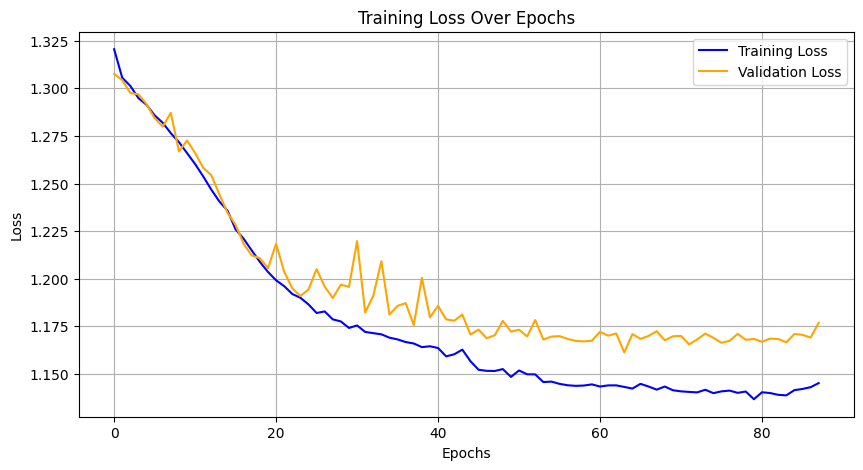

In [68]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(valid_losses, label='Validation Loss', color='orange')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')